In [1]:
#All the imports we will need
import math
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from matplotlib import pyplot as plt
import gc
import time
import tracemalloc

#Custom files
from logP import *
from get_pyrosetta_scores import get_pyrosetta_scores_from_sequence
from bmDCA import *

/home/joseph/summer2020_personal/Bayesian_Optimization/utils.py:2: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.loops.loop_closure.kinematic_closure import *


PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python37.linux 2020.11+release.ce6f14f37b41d7372ea79cca59fad6b33adc1596 2020-03-12T19:59:10] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
[Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', SingleLetterAlphabet()), Seq('EYPYRAKAIYSYEANPANEISFSKHEILEVSDVSGRWWQARKNGETGIAPSNYLILL--', 

In [2]:
#Mock experimental functionality score, currently higher is better                                                                                   
def hammingDist(str1, str2): 
    count = 0 
    for i in range(len(str1)):
        if(str2[i] != str1[i]):
            count+=1
    return count/len(str1)



In [3]:
"""

scalarization of objectives (y) sum of coefficients equals one will minimize "cost" 
calculate scalarized cost for a single y value 

"""
#objects below to assist in consistent scoring and sequence finding
vae = VAE_Operator()
dca = DCA_scorer()

def standardize_multi_dimensional_cost(y_):
    """
        standardizes scores to mean 0, and range -1 to 1
        
        inputs: multi dim score list
        returns: standardize score list
    
    """
    y_standardized = np.array(y_)
    for i in range(len(y_standardized[0])):
        mean = np.mean(y_standardized[:,i])
        std = np.std(y_standardized[:,i])
        y_standardized[:,i] = (y_standardized[:,i]-mean)/std
    return y_standardized
        

def multi_dimensional_cost(x):
    """
        scores point x on four metrics (vae, pyr, dca, functionality)
        ~Important: BO set up to minimize~
        
        inputs: point x (vae latent encoding)
        returns: list of scores [vae, pyr cost, dca, functionality] and new sequence tested
    """
    sequence = vae.get_seq_from_z(x)
    vae_prob = vae.get_score_from_z(x)[0] 
    pyr_score = get_pyrosetta_scores_from_sequence(sequence)
    dca_prob = dca.get_dca_scores_from_seq(sequence)[0] 
    functionality_prob = hammingDist("A"*62, sequence)
    return ([vae_prob*(-1), pyr_score, dca_prob*(-1), functionality_prob*(-1)], sequence)

def scalarized_cost(y_singular,lambda_,rho=0.05):
    """
        scalarizes a single multidimensional (4) score list by some normalized lambda_
        
        inputs: y_singular=a 4 length score array, lambda_=a normalized random vector for bayesian optimization, rho=hyperparameter for tuning
        returns: a single scaralized score
    """
    lambda_ /= np.sum(lambda_)
    p = np.multiply(y_singular, lambda_)
    return np.max(p) + np.sum(p * rho)

def calc_scal_from_observations(y):
    """
        calc scalarized cost for entire run based on scalarized lambda
        
        inputs: np.array of all y scores {(nx4) generally}
        returns: a 1d np.array of scaralized scores for 
    """
    lambda_ = np.random.random(len(y[0]))
    lambda_ /= np.sum(lambda_)
    scalar_scores = np.zeros(len(y))
    y_standardized = standardize_multi_dimensional_cost(y)
    for counter, y_singular in enumerate(y_standardized):
        cost = scalarized_cost(y_singular, lambda_)
        scalar_scores[counter] = cost
    return (scalar_scores, lambda_)

#expected improvement (to be maximized across whole x_space)
def EI(muNew, stdNew, fMax, epsilon=0.01):
    """
    Expected improvement acquisition function
    INPUT:
    - muNew: mean of predicted point in grid
    - stdNew: sigma (square root of variance) of predicted point in grid
    - fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
    - epsilon: trade-off parameter (>=0)
    [Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])
    OUTPUT:
    - EI: expected improvement for candidate point
    As describend in:
    E Brochu, VM Cora, & N de Freitas (2010):
    A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
    arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
    """

    Z = (muNew - fMax - epsilon) / stdNew

    return (muNew - fMax - epsilon) * scipy.stats.norm.cdf(
        Z
    ) + stdNew * scipy.stats.norm.pdf(Z) * (-1)



# BO Minimizes # 


The current build searches for a scalarized **minimum**. This means that VAE, DCA, and Functionality probabilites are multiplied by negative one when scored and reported to the algorithm.

In [24]:
class BO():
    def __init__(self, initial_x, initial_y):
        self.model = GaussianProcessRegressor()
        self.observed_x = initial_x
        self.observed_y = initial_y
        self.observed_y_scalarized, _ = calc_scal_from_observations(self.observed_y)
        self.model.fit(self.observed_x, self.observed_y_scalarized)
        self.average_scores = np.zeros(1)
        self.sequences = []

        
    def propose_new(self, resolution=1000000, dim=3):
        best = np.max(self.observed_y_scalarized)
        
        #with sigma^2 equal to 0.75^2, generate a bunch of random sequences to maximize acq
        x_space = 0.75*np.random.randn(resolution,dim)
        
        mu, std = self.model.predict(x_space, return_std = True)
        #evaluate ei at a bunch of points in x_space
        scores = EI(mu, std, best)
        #maximize ei
        max_i = np.argmax(scores) 
        new_point = x_space[max_i]
        print(new_point, "-suggested new point")
        return new_point
    
    
    def run_BO(self, num_iter=10):
        start_t = time.time()
        time.clock()    
        self.average_scores = np.zeros((num_iter, len(self.observed_y[0])))
        for num_round in range(num_iter):
            #trace memory
            tracemalloc.start()
            
            #1) calculate random scalarization for this round
            self.observed_y_scalarized, lambda_ = calc_scal_from_observations(self.observed_y)
            
            #2) Fit GPR to this scalarization
            self.model.fit(self.observed_x, self.observed_y_scalarized)
            
            #plot current round
            f, axs = plt.subplots(2,2,figsize=(12,4))
            plt.subplot(1,3,1)
            plt.plot(range(len(self.observed_y_scalarized)), self.observed_y_scalarized)
            plt.xlabel("Number of Sequences Tested by BO")
            plt.ylabel("Scalarized Scores (different scalarization each round)")
            plt.title("Round "+ str(num_round)+ " Scalarized Score Plot")
            
            plt.subplot(1,3,2)
            plt.scatter(self.observed_x[:,0], self.observed_x[:,1])
            for i in range(len(self.observed_x[:,0])):
                plt.text(self.observed_x[i,0], self.observed_x[i,1], str(i), fontsize=12)
            plt.scatter(self.observed_x[len(self.observed_x)-1,0], self.observed_x[len(self.observed_x)-1,1], color="green")
            plt.xlabel("Psi 1")
            plt.ylabel("Psi 2")
            
            plt.subplot(1,3,3)
            plt.scatter(self.observed_x[:,0], self.observed_x[:,2])
            for i in range(len(self.observed_x[:,0])):
                plt.text(self.observed_x[i,0], self.observed_x[i,2], str(i), fontsize=12)
            plt.scatter(self.observed_x[len(self.observed_x)-1,0], self.observed_x[len(self.observed_x)-1,2], color="green")
            plt.xlabel("Psi 1")
            plt.ylabel("Psi 3")
            
            plt.tight_layout()
            plt.show()
            print("Round ", num_round, " mean score: ", np.mean(self.observed_y_scalarized))
            print("Random Scalarization (Lambda): ", lambda_)

            #3) Propose new point
            new_point_to_check = self.propose_new()
            
            #4) Score new point
            self.observed_x = np.vstack([self.observed_x, new_point_to_check])
            new_score, new_sequence = multi_dimensional_cost(new_point_to_check)
            self.sequences += [new_sequence]
            self.observed_y = np.vstack([self.observed_y, new_score])
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            print("Peak Memory Used This Round: ", peak)
            
            #5) Calculate average scores for analysis
            for i in range(len(self.observed_y[0])):
                self.average_scores[num_round][i] = np.mean(self.observed_y[:,i])
            print((1.0- num_round/num_iter) * (time.time()-start_t)/(num_round+1))
            print("ETA: ", int((num_iter-num_round) * (time.time()-start_t)/(num_round+1)), " seconds")
            print("------------------------------------------------------------------------")
            print()
            gc.collect()
            np.savetxt("data/round"+str(num_round)+"_observed_points.txt", self.observed_x)
            np.savetxt("data/round"+str(num_round)+"_observed_scores.txt", self.observed_y)


In [5]:
#initialize 3 random points
initial_x = np.random.randn(3,3)

initial_scores = []
initial_sequences = []
for i in initial_x:
    nscore, nseq = multi_dimensional_cost(i)
    initial_sequences += [nseq]
    initial_scores += [nscore]

initial_y = np.array(initial_scores)


In [25]:
bayesian_optimizer = BO(initial_x, initial_y)

/home/joseph/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


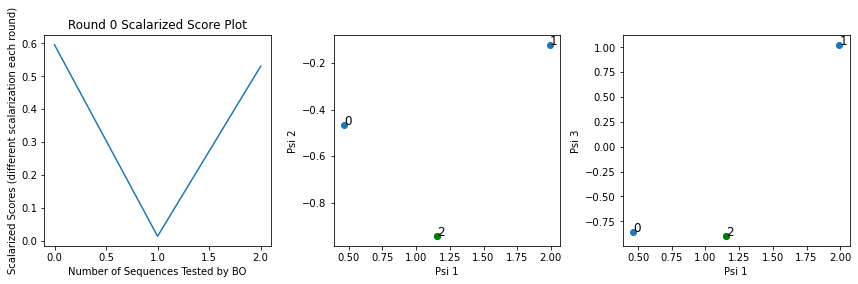

Round  0  mean score:  0.3801585263121461
Random Scalarization (Lambda):  [0.1188877  0.36507897 0.46989468 0.04613865]
[ 1.97440099 -0.05400067  1.03945026] -suggested new point
Peak Memory Used This Round:  131004905
2.5338010787963867
ETA:  76  seconds
------------------------------------------------------------------------



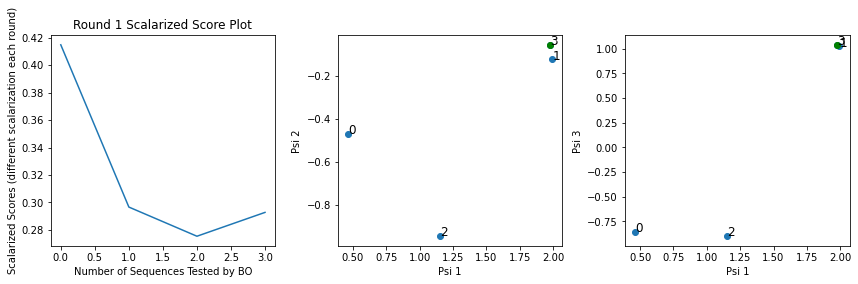

Round  1  mean score:  0.31990440907349227
Random Scalarization (Lambda):  [0.25075177 0.15771569 0.28237428 0.30915825]
[ 1.15091487 -0.93302192 -0.89985645] -suggested new point
Peak Memory Used This Round:  155329408
2.7732747832934064
ETA:  83  seconds
------------------------------------------------------------------------



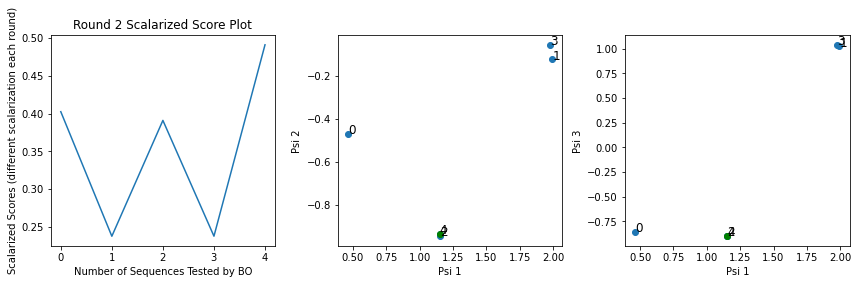

Round  2  mean score:  0.35185071996942285
Random Scalarization (Lambda):  [0.16072542 0.34932621 0.25543328 0.23451509]
[ 1.55730821 -0.0551252  -0.9586335 ] -suggested new point
Peak Memory Used This Round:  187262436
2.7829614851209854
ETA:  83  seconds
------------------------------------------------------------------------



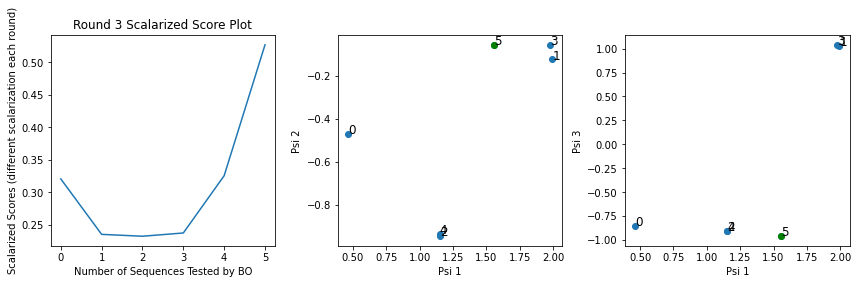

Round  3  mean score:  0.3131534094536982
Random Scalarization (Lambda):  [0.2143402  0.35379471 0.14769423 0.28417085]
[ 1.14458942 -0.43633024 -0.72265845] -suggested new point
Peak Memory Used This Round:  219322407
2.701303446292877
ETA:  81  seconds
------------------------------------------------------------------------



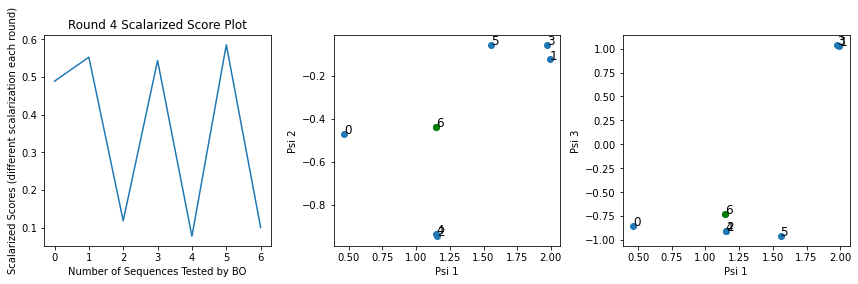

Round  4  mean score:  0.3524427933777262
Random Scalarization (Lambda):  [0.07212217 0.10866313 0.27752356 0.54169114]
[ 1.27945439 -2.12900961 -0.70232324] -suggested new point
Peak Memory Used This Round:  251379735
2.6179640324910483
ETA:  78  seconds
------------------------------------------------------------------------



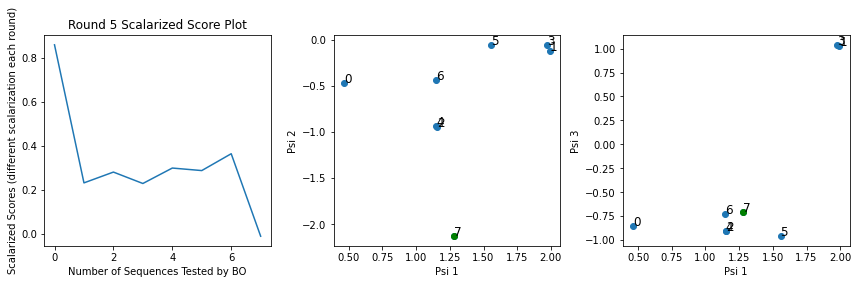

Round  5  mean score:  0.31715174982833183
Random Scalarization (Lambda):  [0.50676027 0.11658734 0.13242091 0.24423148]
[ 0.84644805 -0.42583863 -1.57069609] -suggested new point
Peak Memory Used This Round:  283335691
2.5130992796685963
ETA:  75  seconds
------------------------------------------------------------------------



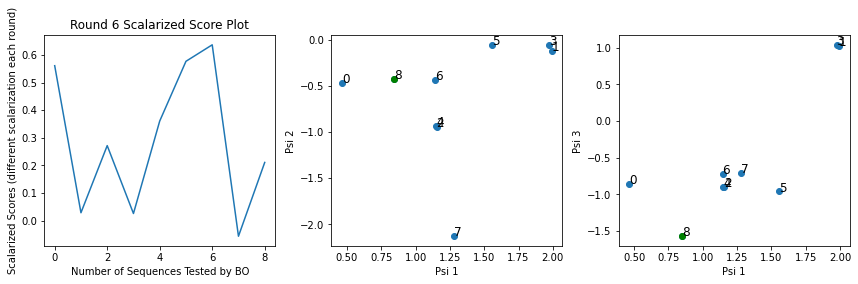

Round  6  mean score:  0.29043514946499444
Random Scalarization (Lambda):  [0.20968957 0.41915898 0.29156691 0.07958454]
[ 1.3862716  -2.89801761 -0.13369686] -suggested new point
Peak Memory Used This Round:  315339316
2.4258392061506
ETA:  72  seconds
------------------------------------------------------------------------



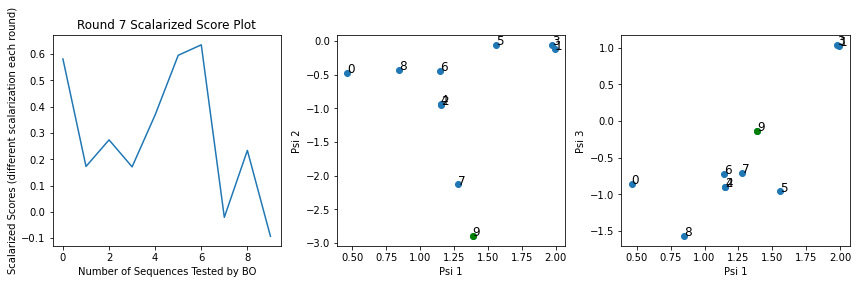

Round  7  mean score:  0.29210626703233267
Random Scalarization (Lambda):  [0.04554324 0.40068156 0.36766246 0.18611273]
[ 1.30586468 -2.92523959 -1.32788491] -suggested new point
Peak Memory Used This Round:  347438338
2.3854040910800296
ETA:  71  seconds
------------------------------------------------------------------------



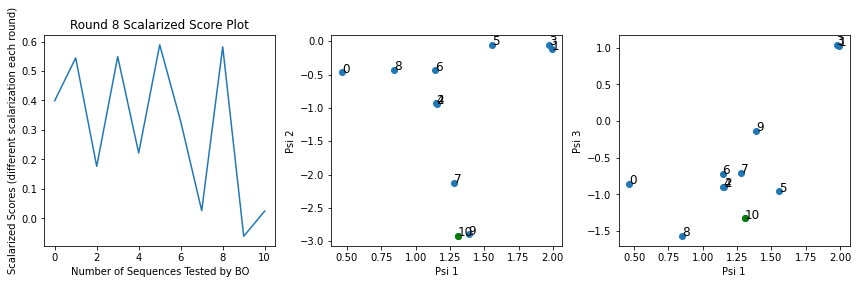

Round  8  mean score:  0.30741845294746395
Random Scalarization (Lambda):  [0.27863027 0.21311383 0.01482749 0.49342841]
[ 1.66568675 -0.30799872 -1.40738391] -suggested new point
Peak Memory Used This Round:  379469625
2.281333605448405
ETA:  68  seconds
------------------------------------------------------------------------



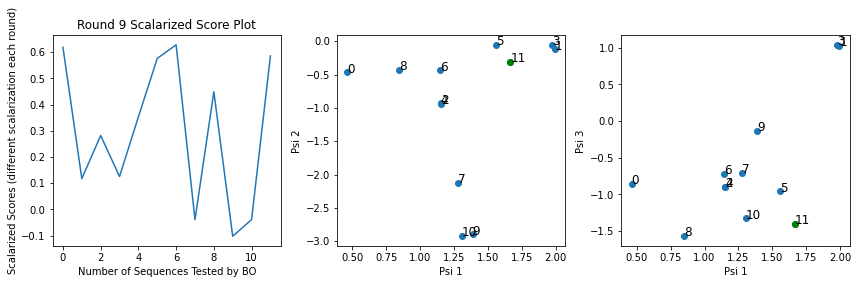

Round  9  mean score:  0.29596634447797504
Random Scalarization (Lambda):  [0.41362707 0.41295052 0.020648   0.15277441]
[ 0.97759366 -0.55372039 -1.11828152] -suggested new point
Peak Memory Used This Round:  411508245
2.180783257484436
ETA:  65  seconds
------------------------------------------------------------------------



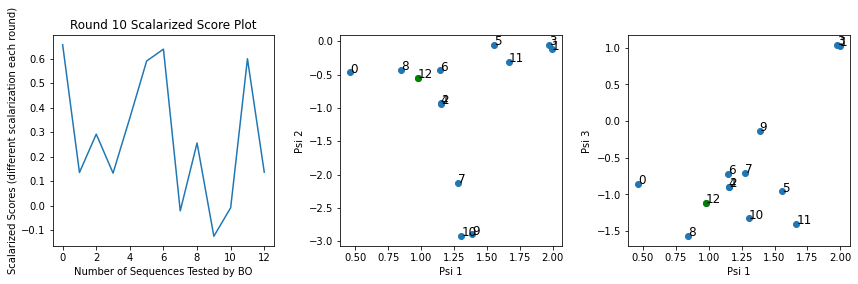

Round  10  mean score:  0.2801040241278876
Random Scalarization (Lambda):  [0.0630358  0.40191343 0.37890972 0.15614106]
[ 2.33798907 -0.2329121  -0.5987663 ] -suggested new point
Peak Memory Used This Round:  443552519
2.0765868967229673
ETA:  62  seconds
------------------------------------------------------------------------



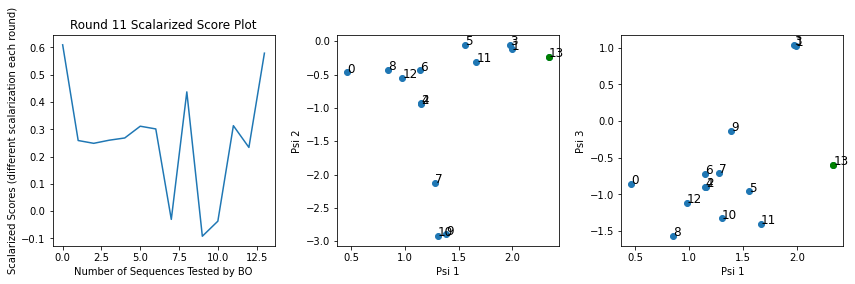

Round  11  mean score:  0.2614788515689347
Random Scalarization (Lambda):  [0.39352674 0.18217349 0.09436815 0.32993162]
[-0.08325023 -1.07377259 -0.40413973] -suggested new point
Peak Memory Used This Round:  475426577
1.9735803412066566
ETA:  59  seconds
------------------------------------------------------------------------



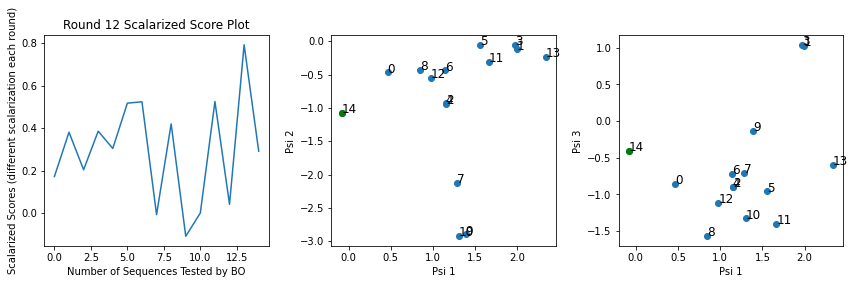

Round  12  mean score:  0.29588965128269534
Random Scalarization (Lambda):  [0.12897759 0.33940701 0.09599097 0.43562444]
[-0.05873203 -0.22658391 -2.34004889] -suggested new point
Peak Memory Used This Round:  507420599
1.855242600807777
ETA:  55  seconds
------------------------------------------------------------------------



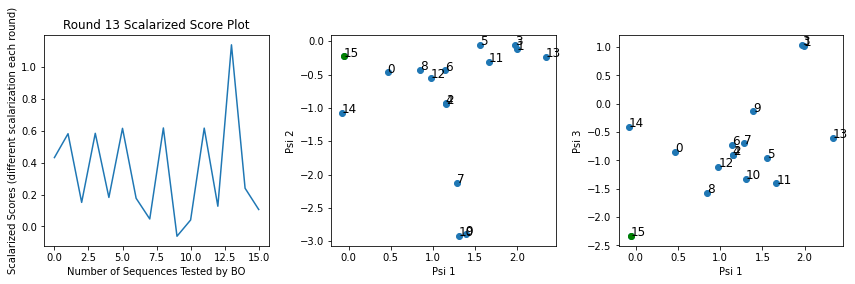

Round  13  mean score:  0.3492469999723712
Random Scalarization (Lambda):  [0.29646302 0.10720393 0.00093184 0.59540121]
[ 2.21143753  0.76143299 -1.28341113] -suggested new point
Peak Memory Used This Round:  539532396
1.7467942164057777
ETA:  52  seconds
------------------------------------------------------------------------



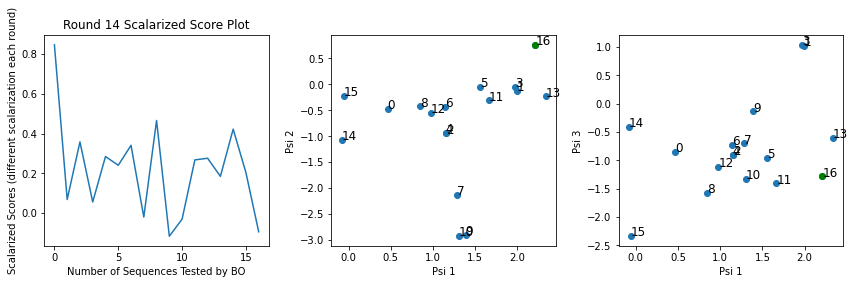

Round  14  mean score:  0.22065822560323656
Random Scalarization (Lambda):  [0.41464044 0.06715648 0.42546351 0.09273957]
[ 1.64436157 -1.64683636 -1.81841725] -suggested new point
Peak Memory Used This Round:  571476867
1.6461025831434462
ETA:  49  seconds
------------------------------------------------------------------------



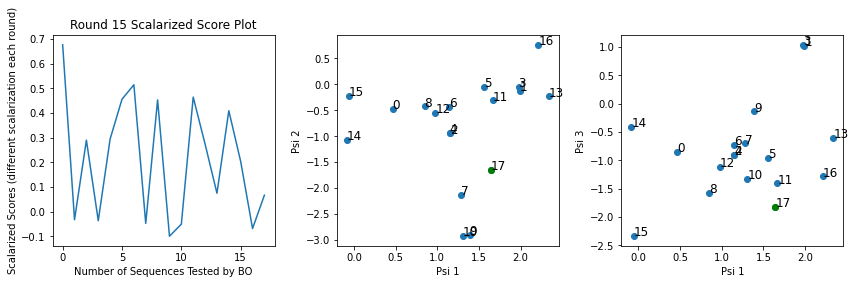

Round  15  mean score:  0.2137329249343509
Random Scalarization (Lambda):  [0.40416326 0.27063707 0.31145502 0.01374466]
[-0.03754019 -0.3044008  -0.74610836] -suggested new point
Peak Memory Used This Round:  603595511
1.5668307542800903
ETA:  47  seconds
------------------------------------------------------------------------



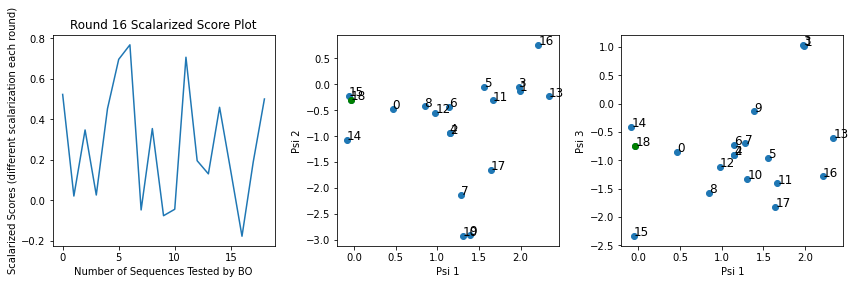

Round  16  mean score:  0.2721960436755613
Random Scalarization (Lambda):  [0.35305792 0.41183374 0.14469954 0.0904088 ]
[ 0.92066474 -0.85630593 -2.71696715] -suggested new point
Peak Memory Used This Round:  635553097
1.4665239904441085
ETA:  43  seconds
------------------------------------------------------------------------



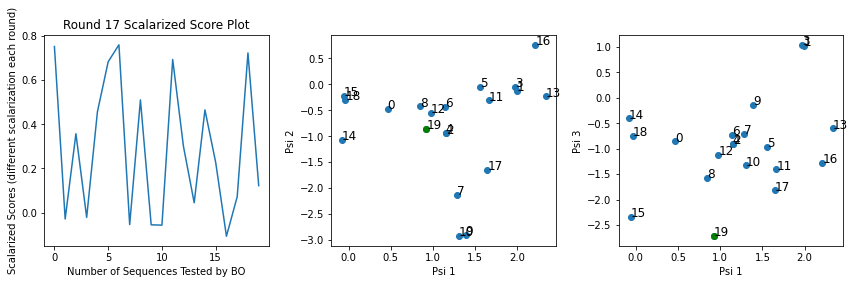

Round  17  mean score:  0.2922457137313791
Random Scalarization (Lambda):  [0.48965489 0.39327355 0.06569863 0.05137293]
[ 1.65084602 -2.05028469 -2.14138518] -suggested new point
Peak Memory Used This Round:  667550121
1.38021339752056
ETA:  41  seconds
------------------------------------------------------------------------



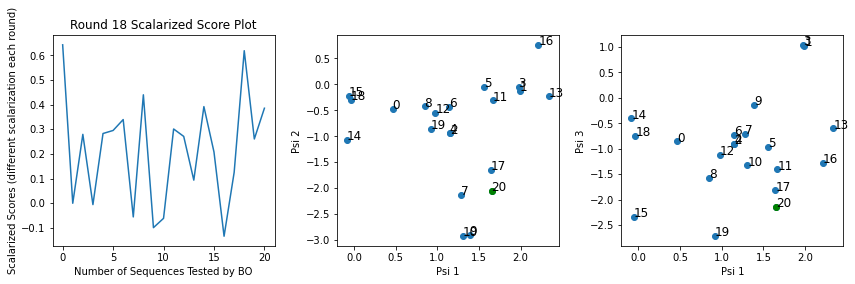

Round  18  mean score:  0.2180190334500163
Random Scalarization (Lambda):  [0.40225762 0.19609182 0.31076663 0.09088393]
[ 0.22186768 -0.64403546 -0.75649468] -suggested new point
Peak Memory Used This Round:  699656488
1.2954969707288242
ETA:  38  seconds
------------------------------------------------------------------------



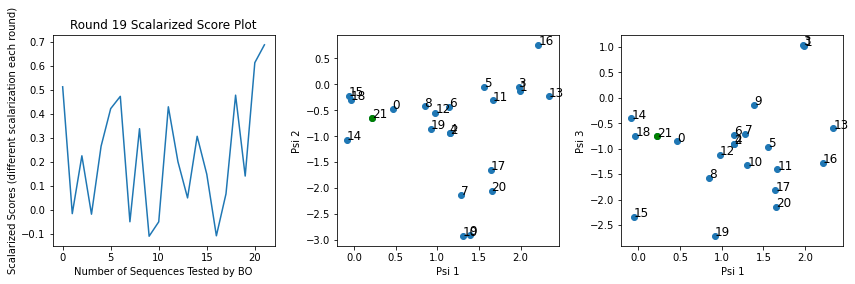

Round  19  mean score:  0.2277217049128066
Random Scalarization (Lambda):  [0.33647423 0.2991665  0.30824765 0.05611162]
[ 2.18869872 -2.59283151 -1.22561473] -suggested new point
Peak Memory Used This Round:  731700258
1.1938772686322532
ETA:  35  seconds
------------------------------------------------------------------------



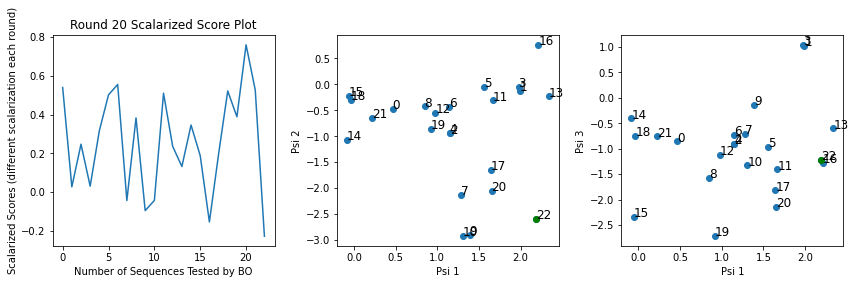

Round  20  mean score:  0.25414211280613935
Random Scalarization (Lambda):  [0.37229004 0.34547808 0.145538   0.13669388]
[ 0.26815768 -1.58858778  0.38973658] -suggested new point
Peak Memory Used This Round:  763654156
1.0860983038705494
ETA:  32  seconds
------------------------------------------------------------------------



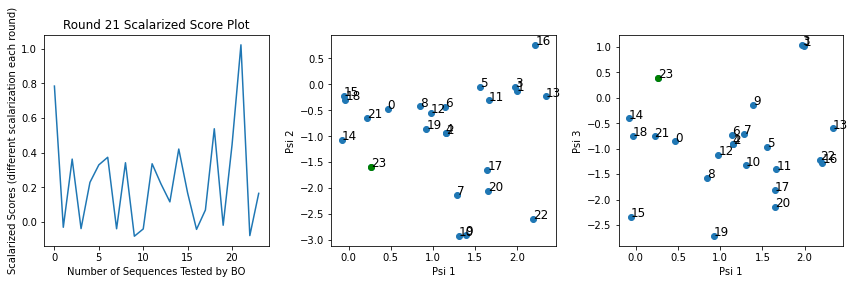

Round  21  mean score:  0.2315375242445822
Random Scalarization (Lambda):  [0.31547174 0.22441284 0.45746411 0.00265131]
[0.88365773 0.36090857 0.09714508] -suggested new point
Peak Memory Used This Round:  795676760
0.9781488743695348
ETA:  29  seconds
------------------------------------------------------------------------



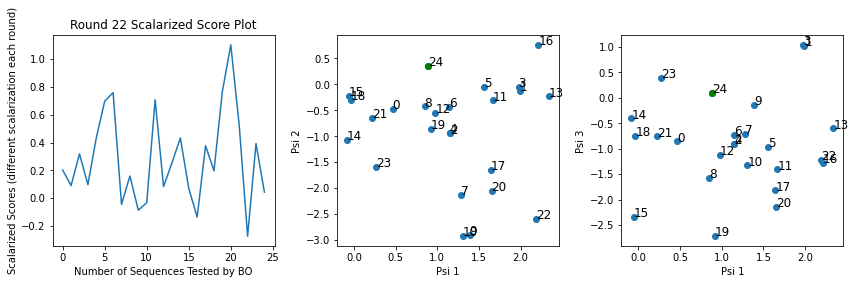

Round  22  mean score:  0.2862053982957285
Random Scalarization (Lambda):  [0.14612125 0.4780017  0.12679446 0.24908259]
[0.51154079 1.24296969 0.45522779] -suggested new point
Peak Memory Used This Round:  827740579
0.8749412702477499
ETA:  26  seconds
------------------------------------------------------------------------



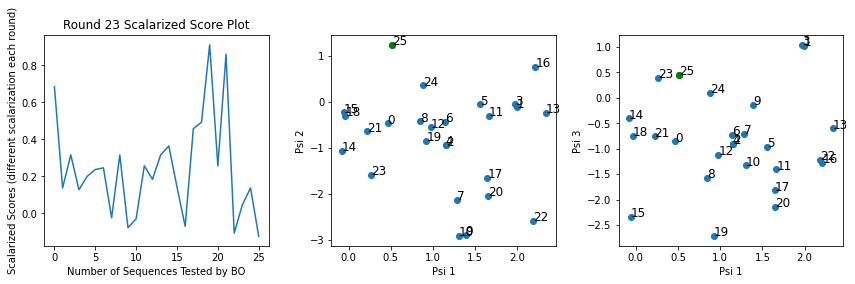

Round  23  mean score:  0.24080123047145194
Random Scalarization (Lambda):  [0.27595567 0.06286025 0.37882655 0.28235753]
[ 0.179765   -1.72683227 -1.52814878] -suggested new point
Peak Memory Used This Round:  859660077
0.7728300306532115
ETA:  23  seconds
------------------------------------------------------------------------



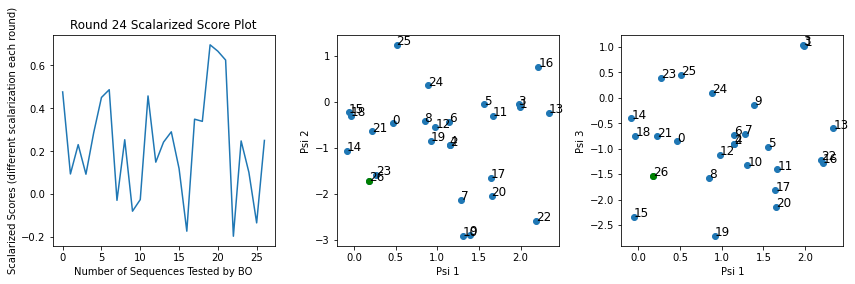

Round  24  mean score:  0.23240201960741078
Random Scalarization (Lambda):  [0.21665971 0.30133913 0.26668054 0.21532062]
[-0.07965212 -2.69215994 -0.84850853] -suggested new point
Peak Memory Used This Round:  891682525
0.6633541507720946
ETA:  19  seconds
------------------------------------------------------------------------



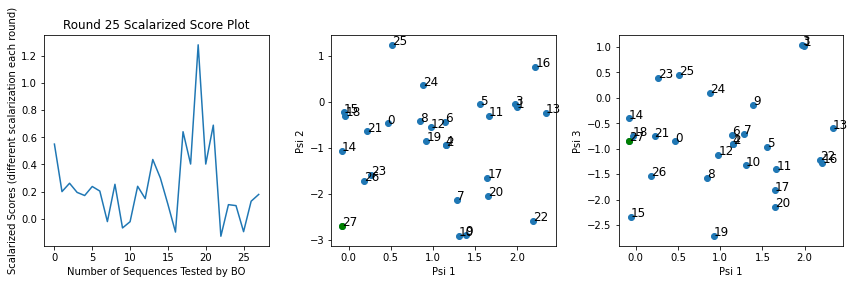

Round  25  mean score:  0.2425044090242326
Random Scalarization (Lambda):  [0.18731987 0.12583718 0.30252061 0.38432233]
[ 3.21551839 -0.63094758 -0.67277425] -suggested new point
Peak Memory Used This Round:  923749353
0.5585317489428397
ETA:  16  seconds
------------------------------------------------------------------------



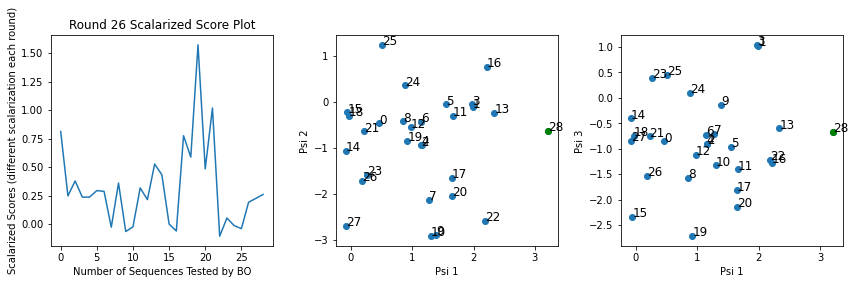

Round  26  mean score:  0.3163497080127874
Random Scalarization (Lambda):  [0.01727321 0.0673445  0.44962214 0.46576015]
[ 1.04328998 -3.35164898  0.57932789] -suggested new point
Peak Memory Used This Round:  955721933
0.44849187591929485
ETA:  13  seconds
------------------------------------------------------------------------



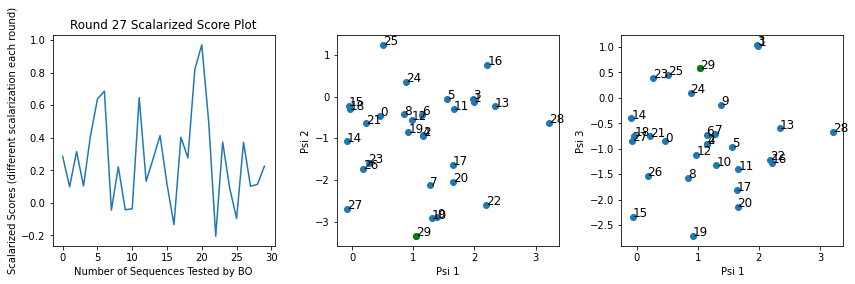

Round  27  mean score:  0.26714184855812817
Random Scalarization (Lambda):  [0.17594155 0.40200358 0.16973351 0.25232136]
[-0.13295384  0.97051373 -1.23660301] -suggested new point
Peak Memory Used This Round:  987763046
0.33868290867124273
ETA:  10  seconds
------------------------------------------------------------------------



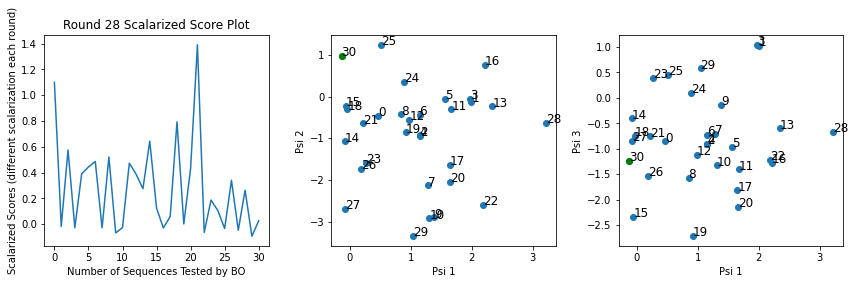

Round  28  mean score:  0.2770398056293427
Random Scalarization (Lambda):  [0.17720377 0.19793153 0.62391814 0.00094656]
[ 2.10651233  0.25819702 -2.43010396] -suggested new point
Peak Memory Used This Round:  1019804326
0.2266522802155593
ETA:  6  seconds
------------------------------------------------------------------------



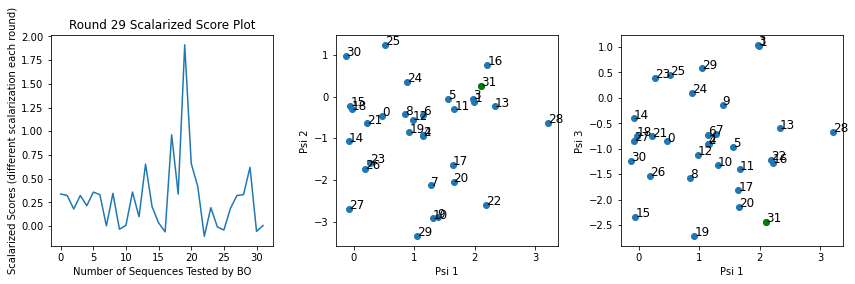

Round  29  mean score:  0.29525139830355374
Random Scalarization (Lambda):  [0.02508581 0.19988661 0.20101737 0.57401021]
[ 2.01294855 -1.32060913 -2.03893652] -suggested new point
Peak Memory Used This Round:  1051849520
0.11396486467785304
ETA:  3  seconds
------------------------------------------------------------------------



In [26]:
num_rounds = 30
bayesian_optimizer.sequences = initial_sequences
bayesian_optimizer.run_BO(num_rounds)

# Plotting and Analysis #
The *ploting.ipynb* has some example code to do preliminary analysis. The scores of each round are saved in the data folder. 

VAE, DCA, and functionality are reported as costs, so to retrieve the probabilites, one must multiply these columns by negative one

In [32]:
#"next sequence" to check
bayesian_optimizer.sequences[-1]

'HPGDKVAVLWAYQPRADDGDEFELERGDMLKVVGIWDGWATGVRARAEDYWERRKVQRRSGV'

In [33]:
#for human readable probabilites/costs
def revert_scores(s):
    s[0] = -1*s[0]
    s[2] = -1*s[2]
    s[3] = -1*s[3]
    return s

In [35]:
#scoring example 1
scores, sequence = multi_dimensional_cost([0.5,0.5,0.5])
scores = revert_scores(scores)
print("VAE: %8.2f    Pyrosetta: %8.2f DCA: %8.2f Functionality: %8.2f Sequence: %s" % tuple(scores+[sequence]))

VAE:    -1.20    Pyrosetta:   633.40 DCA:   119.01 Functionality:     0.94 Sequence: GNYGLAIALYDYHSTEDDDGDLTFAEGDKIVLIERINNWLVGKSADGPEGMFPLNYVSEK--


In [37]:
#scoring example 1
scores, sequence = multi_dimensional_cost([0.6,0.4,0.5])
scores = revert_scores(scores)
print("VAE: %8.2f    Pyrosetta: %8.2f DCA: %8.2f Functionality: %8.2f Sequence: %s" % tuple(scores+[sequence]))

VAE:    -0.99    Pyrosetta:  3403.25 DCA:   129.31 Functionality:     0.94 Sequence: KNKVEVKALYDYEAQEDDLDELSFNKGDVIVDTEKDDGWWVGKLARGKEGWFPSNYVSAMYK
